In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torchvision.models

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/2020\ Winter/APS360/Project

In [0]:
vgg_m = torchvision.models.vgg16_bn(True).features.to(device).eval()
for param in vgg_m.parameters():
    param.requires_grad = False

In [0]:
blocks = [i-1 for i, o in enumerate(vgg_m.children()) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [0]:
def _hook_fn(m, i, o):
        return o if isinstance(o, torch.Tensor) else o if isinstance(o,(list, tuple)) else list(o)

_base_loss = F.l1_loss

def _gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

class Hook():
    def __init__(self, m, hook_func, detach=False):
        self.hook_func, self.detach, self.stored = hook_func, detach, None
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        if self.detach:
            input  = (o.detach() for o in input) if isinstance(input,  (list, tuple)) else input.detach()
            output = (o.detach() for o in input) if isinstance(output, (list, tuple)) else output.detach()
        self.stored = self.hook_func(module, input, output)

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = [Hook(m, _hook_fn, detach=False) for m in self.loss_features]
        self.wgts = layer_wgts
        self.matric_names = ["pixel", ] + [f"feat_{i}" for i in range(len(layer_ids))] + \
                            [f"gram_{i}" for i in range(len(layer_ids))]

    

    def make_features(self, x, clone=False):
        self.m_feat(x) 
        return [(o.stored.clone() if clone else o.stored) for o in self.hooks]

    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [_base_loss(input, target)]
        self.feat_losses += [_base_loss(f_in, f_out)*w 
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [_base_loss(_gram_matrix(f_in), _gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.matric_names, self.feat_losses))
        return sum(self.feat_losses)


In [0]:
import os
from torch.utils.data import Dataset
from skimage import io
from PIL import Image

class UTKFaceDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.path, self.dirs, self.files = os.walk(root_dir).__next__()
        self.files = self.files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.files[idx])
        image = io.imread(img_name)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.up(x)
        return self.conv(x)


# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(x)



In [0]:
# class Stage1Autoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.name = "Stage1Autoencoder"
#         self.conv1 = nn.Conv2d(3, 16, 5)

#         self.pool = nn.MaxPool2d(2, 2)
#         self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
#         self.t_conv1 = nn.ConvTranspose2d(16, 3, 5)

#     def forward(self,x):
#         # print(x.shape)
#         x = F.relu(self.conv1(x))
#         # print(x.shape)
#         x = self.pool(x)
#         # print(x.shape)
#         x = self.upsample(x)
#         # print(x.shape)
#         x = self.t_conv1(x)
#         # x = F.sigmoid(x)
#         # print(x.shape)
#         return x

In [0]:
class Stg1En(nn.Module):
    def __init__(self, n_channels=3):
        super().__init__()
        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 16)
        self.down2 = Down(16, 16)

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        return x

class Stg1De(nn.Module):
    def __init__(self, n_channels=3, bilinear=True):
        super().__init__()
        self.up1 = Up(16, 16, bilinear)
        self.up2 = Up(16, 16, bilinear)
        self.outc = OutConv(16, n_channels)

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.outc(x)
        return x

In [0]:
class Stg1AE(nn.Module):
    def __init__(self, n_channels=3, bilinear=True):
        super().__init__()
        self.name = "Stg1AE"
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.En = Stg1En(self.n_channels)
        self.De = Stg1De(self.n_channels)
        

    def forward(self, x, debug=False):
        x = self.En(x)
        if debug: print(x.shape)
        x = self.De(x)
        if debug: print(x.shape)
        return x

In [0]:
# test_m = Stage1Autoencoder()
# test_m.to(device)
# test_m(test[10].unsqueeze(0).to(device))

In [0]:
from torch.utils.data import DataLoader

def train(model, train_loader, criterion, num_epochs=5, learning_rate=1e-4, chkpt_path=None, vis_path=None, starting_iter=0):
    torch.manual_seed(42)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iter_n = starting_iter

    if iter_n == 0:
        if vis_path:
            visualize(model, train_loader.dataset, show=False, path=vis_path + "_" + str(iter_n))
        
        if chkpt_path:
            torch.save(model, chkpt_path + "_" + str(iter_n))

    for epoch in range(num_epochs):
        for data in train_loader:
            data = data.float().to(device)
            recon = model(data.clone())
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iter_n += 1
            print("Iter: {:5d} Loss: {:2.4f}".format(iter_n, float(loss)))

            if iter_n % 1000 == 0:
                if vis_path:
                    visualize(model, train_loader.dataset, show=False, path=vis_path + "_" + str(iter_n))
                
                if chkpt_path:
                    torch.save(model, chkpt_path + "_" + str(iter_n))
    
    if vis_path:
        visualize(model, train_loader.dataset, show=False, path=vis_path + "_" + str(iter_n))
    
    if chkpt_path:
        torch.save(model, chkpt_path + "_" + str(iter_n))

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(model, dataset, show=True, path=None):

    assert len(dataset) >= 10, "Dataset Not Large Enough"

    fig = plt.figure(figsize=(7, 10))
    indices = np.random.choice(list(range(len(dataset))), size=10)

    for idx, id in enumerate(indices, 1):
        ax = fig.add_subplot(5, 4, idx * 2 - 1, xticks=[], yticks=[])
        plt.imshow(dataset[id].permute(1, 2, 0))
        ax = fig.add_subplot(5, 4, idx * 2, xticks=[], yticks=[])
        output = model(dataset[id].unsqueeze(0).to(device)).detach().squeeze().permute(1, 2, 0).cpu().numpy().clip(0., 1.)
        plt.imshow(output)
        # ax.set_title(idx)
    
    if show:
        plt.show()
    if path:
        fig.savefig(path)

In [0]:
# transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
#                                 transforms.Resize((32, 32)),
#                                 transforms.ToTensor()])

# transform = transforms.Compose([transforms.Resize((224, 224)),
#                                 transforms.ToTensor()])
# test = UTKFaceDataset("/content/drive/My Drive/2020 Winter/APS360/Project/UTKFace_augmentation/UTKFace_cropped_aligned/", transform=transform)

In [0]:
# small_train_loader = DataLoader(dataset=test, batch_size=32, num_workers=8)

In [0]:
# test_m = Stg1AE()
# test_m.to(device)
# test_m(test[10].unsqueeze(0).to(device), debug=True)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [0]:
# feat_loss(test[10].unsqueeze(0).to(device), test[10].unsqueeze(0).to(device))

In [0]:
# train(test_m, small_train_loader, feat_loss, 20, 1e-3, "./checkpoints/" + test_m.name, "./visualizations/" + test_m.name)

In [0]:
# !ls ./checkpoints/
# !ls ./visualizations/

In [0]:
# test_m = torch.load("./checkpoints/Stg1AE_12000")

In [0]:
# visualize(test_m, test, show=False, path="./test_out.png")

In [0]:
# from IPython.display import HTML, display
# from IPython.display import clear_output
# import pickle
# import h5py

# def progress(value, max=100):
#     return HTML("""
#         <progress
#             value='{value}'
#             max='{max}',
#             style='width: 100%'
#         >
#             {value}
#         </progress>
#     """.format(value=value, max=max))


# test_m.eval()

# for param in test_m.parameters():
#     param.requires_grad = False

# stg1_en = test_m.En

# _stg1_loader = DataLoader(dataset=test, batch_size=1, num_workers=8)

# prgsbar = display(progress(0, len(_stg1_loader.dataset)), display_id=True)

# print("Creating HDF5 File".center(50, "-"))

# stg1_dataset = h5py.File("./stg1_dataset.hdf5", "w")

# stg1_feature = stg1_dataset.create_dataset("stg1_feature", shape=(23702, 16, 56, 56))

# stg1_label = stg1_dataset.create_dataset("stg1_label", shape=(23702, 3, 224, 224))

# print("Finished Creating HDF5 File".center(50, "-"))

# for id, data in enumerate(_stg1_loader):
#     stg1_label[id] = data.detach().squeeze().cpu().numpy()
#     data = data.to(device)
#     out = stg1_en(data)
#     stg1_feature[id] = out.cpu().detach().squeeze().cpu().numpy()

#     if (id + 1) % 100 == 0:
#         clear_output()
#         prgsbar.update(progress(id+1, len(_stg1_loader.dataset)))
#         print("Progress: {:5d} / {:5d}".format(id+1, len(_stg1_loader.dataset)))

# stg1_dataset.close()

In [0]:
# !rm -rf stage1_dataset
# !ls

In [0]:
test_m = torch.load("./checkpoints/Stg1AE_12000")

test_m.eval()

for param in test_m.parameters():
    param.requires_grad = False

stg1_en = test_m.En

stg1_de = test_m.De

In [0]:
import os
from torch.utils.data import Dataset
import h5py

class Stage2Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, lbl_path, feat_path, transform=None):
        super().__init__()
        self.transform = transform
        self.lbl_file = h5py.File(lbl_path, "r")
        self.feat_file = h5py.File(feat_path, "r")
        self.labels = self.lbl_file["label"]
        self.features = self.feat_file["stg1_feature"]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # img_name = os.path.join(self.root_dir,
        #                         self.files[idx])
        # image = io.imread(img_name)
        # image = Image.fromarray(image)

        feature = self.features[idx]
        label = self.labels[idx]

        if self.transform:
            feature = self.transform(feature)
            label = self.transform(label)
        
        feature = torch.Tensor(feature)
        label = torch.Tensor(label)

        return feature, label

In [0]:
# stg2_transform = transforms.Compose([transforms.ToTensor()])
stg2_dataset = Stage2Dataset("./labels.hdf5", "stg1_features.hdf5", None)

In [0]:
stg2_loader = DataLoader(dataset=stg2_dataset, batch_size=32, num_workers=8, shuffle=True)

In [0]:
# import matplotlib.pyplot as plt

# _test_id = np.random.randint(0, 23702)
# plt.figure()
# plt.imshow(stg2_dataset[_test_id][1].permute(1, 2, 0))
# plt.show()
# stg1_test_out = stg1_de(stg2_dataset[_test_id][0].unsqueeze(0).to(device))
# plt.figure()
# plt.imshow(stg1_test_out.squeeze().permute(1, 2, 0).cpu().detach().numpy().clip(0, 1))
# plt.show()

In [0]:
class Stg2En(nn.Module):
    def __init__(self, n_channels=16):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 64)
        self.down2 = Down(64, 64)

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        return x

class Stg2De(nn.Module):
    def __init__(self, n_channels=16, bilinear=True):
        super().__init__()
        self.up1 = Up(64, 64, bilinear)
        self.up2 = Up(64, 64, bilinear)
        self.outc = OutConv(64, n_channels)

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.outc(x)
        return x

In [0]:
class Stg2AE(nn.Module):
    def __init__(self, n_channels=16, bilinear=True):
        super().__init__()
        self.name = "Stg2AE"
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.En = Stg2En(self.n_channels)
        self.De = Stg2De(self.n_channels)
        

    def forward(self, x, debug=False):
        x = self.En(x)
        if debug: print(x.shape)
        x = self.De(x)
        if debug: print(x.shape)
        return x

In [0]:
# stg2_m = Stg2AE()
# stg2_m.to(device)

# stg2_m(stg2_dataset[_test_id][0].unsqueeze(0).to(device), debug=True)

In [0]:
stg2_m = torch.load("./checkpoints/Stg2AE_16920")

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_stg2(model, dataset, show=True, path=None):

    assert len(dataset) >= 10, "Dataset Not Large Enough"

    fig = plt.figure(figsize=(7, 10))
    indices = np.random.choice(list(range(len(dataset))), size=10)

    for idx, id in enumerate(indices, 1):
        ax = fig.add_subplot(5, 4, idx * 2 - 1, xticks=[], yticks=[])
        plt.imshow(dataset[id][1].permute(1, 2, 0))
        ax = fig.add_subplot(5, 4, idx * 2, xticks=[], yticks=[])
        output = stg1_de(model(dataset[id][0].unsqueeze(0).to(device))).detach().squeeze().permute(1, 2, 0).cpu().numpy().clip(0., 1.)
        plt.imshow(output)
        # ax.set_title(idx)
    
    if show:
        plt.show()
    if path:
        fig.savefig(path)

In [0]:
from torch.utils.data import DataLoader
from IPython.display import clear_output

def train_stg2(model, train_loader, criterion, num_epochs=5, learning_rate=1e-4, chkpt_path=None, vis_path=None, starting_iter=0):
    torch.manual_seed(42)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iter_n = starting_iter

    if iter_n == 0:
        if vis_path:
            visualize_stg2(model, train_loader.dataset, show=False, path=vis_path + "_" + str(iter_n))
        
        if chkpt_path:
            torch.save(model, chkpt_path + "_" + str(iter_n))

    for epoch in range(num_epochs):
        for data, label in train_loader:
            label = label.float().to(device)
            data = data.float().to(device)
            recon = model(data)
            recon_de = stg1_de(recon)
            loss = criterion(recon_de, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iter_n += 1
            print("Iter: {:5d} Loss: {:2.4f}".format(iter_n, float(loss)))

            if iter_n % 100 == 0:
                output_clear()
                
                if vis_path:
                    visualize_stg2(model, train_loader.dataset, show=False, path=vis_path + "_" + str(iter_n))
                
                if chkpt_path:
                    torch.save(model, chkpt_path + "_" + str(iter_n))
    
    if vis_path:
        visualize_stg2(model, train_loader.dataset, show=False, path=vis_path + "_" + str(iter_n))
    
    if chkpt_path:
        torch.save(model, chkpt_path + "_" + str(iter_n))

In [0]:
# feat_loss_stg2 = FeatureLoss(vgg_m, blocks[2:5], [3,9,1.2])

In [0]:
# output_clear = clear_output
# train_stg2(stg2_m, stg2_loader, feat_loss, 20, 5e-4, "./checkpoints/" + stg2_m.name, "./visualizations/" + stg2_m.name, starting_iter=2100)

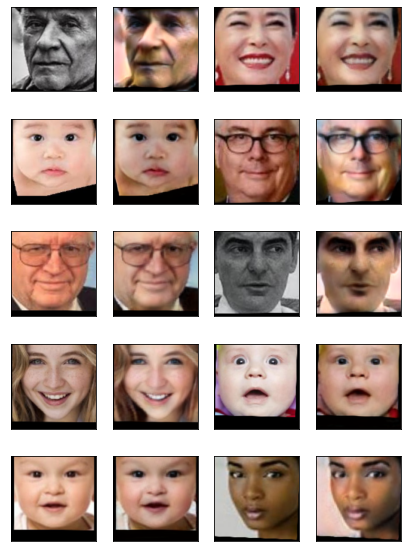

In [0]:

# fig = plt.figure(figsize=(7, 10))
# indices = np.random.choice(list(range(len(stg2_loader.dataset))), size=10)

# for idx, id in enumerate(indices, 1):
#     ax = fig.add_subplot(5, 4, idx * 2 - 1, xticks=[], yticks=[])
#     plt.imshow(stg2_loader.dataset[id][1].permute(1, 2, 0))
#     ax = fig.add_subplot(5, 4, idx * 2, xticks=[], yticks=[])
#     output = stg1_de(stg2_m(stg2_loader.dataset[id][0].unsqueeze(0).to(device))).detach().squeeze().permute(1, 2, 0).cpu().numpy().clip(0., 1.)
#     plt.imshow(output)
#     # ax.set_title(idx)

# fig.savefig("./visualizations/" + stg2_m.name + "16920")

In [0]:
# from IPython.display import HTML, display
# from IPython.display import clear_output
# import pickle
# import h5py

# def progress(value, max=100):
#     return HTML("""
#         <progress
#             value='{value}'
#             max='{max}',
#             style='width: 100%'
#         >
#             {value}
#         </progress>
#     """.format(value=value, max=max))


# stg2_m.eval()

# for param in stg2_m.parameters():
#     param.requires_grad = False

# stg2_en = stg2_m.En


# prgsbar = display(progress(0, 23702), display_id=True)

# print("Creating HDF5 File".center(50, "-"))

# stg2_dataset = h5py.File("./stg2_features.hdf5", "w")

# stg2_feature = stg2_dataset.create_dataset("stg2_feature", shape=(23702, 64, 14, 14))

# print("Finished Creating HDF5 File".center(50, "-"))

# stg1_file = h5py.File("./stg1_features.hdf5", "r")

# stg1_feature = stg1_file["stg1_feature"]

# for id in range(23702):
#     data = torch.tensor(stg1_feature[id]).unsqueeze(0).to(device)
#     out = stg2_en(data)
#     stg2_feature[id] = out.cpu().detach().squeeze().cpu().numpy()

#     if (id + 1) % 100 == 0:
#         clear_output()
#         prgsbar.update(progress(id+1, 23702))
#         print("Progress: {:5d} / {:5d}".format(id+1, 23702))

# stg2_dataset.close()

In [0]:
# !ls -lh stg2_features.hdf5

In [0]:
label_file = h5py.File("./labels.hdf5", "r")

labels = label_file["label"]

In [0]:
stg2_dataset = h5py.File("./stg2_features.hdf5", "r")

stg2_feature = stg2_dataset["stg2_feature"]

In [0]:
labels[0].shape

(3, 224, 224)

In [0]:
stg2_m.eval()

for param in stg2_m.parameters():
    param.requires_grad = False

stg2_en = stg2_m.En

stg2_de = stg2_m.De

In [0]:
# import matplotlib.pyplot as plt

# _test_transform = transforms.Compose([transforms.Resize((224, 224)),
#                                 transforms.ToTensor()])

# _test_image = io.imread("/content/Annotation 2020-03-21 114506.png")
# _test_image = Image.fromarray(_test_image).convert('RGB')
# _test_image = _test_transform(_test_image)

# plt.figure()
# plt.imshow(np.transpose(_test_image, (1, 2, 0)))
# plt.show()
# stg2_test_out = stg1_de(stg2_de(stg2_en(stg1_en(_test_image.unsqueeze(0).to(device)))))
# plt.figure()
# plt.imshow(stg2_test_out.squeeze().permute(1, 2, 0).cpu().detach().numpy().clip(0, 1))
# plt.show()

# feat_loss(stg2_test_out, _test_image.unsqueeze(0).to(device))

In [0]:
class Stg3En(nn.Module):
    def __init__(self, n_channels=64):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 64)
        self.linear = nn.Linear(64*7*7, 1000)

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = x.view((-1, 64*7*7))
        x = self.linear(x)
        return x

class Stg3De(nn.Module):
    def __init__(self, n_channels=64, bilinear=True):
        super().__init__()
        self.linear = nn.Linear(1000, 64*7*7)
        self.up1 = Up(64, 64, bilinear)
        self.outc = OutConv(64, n_channels)

    def forward(self, x):
        x = self.linear(x)
        x = x.view((-1, 64, 7, 7))
        x = self.up1(x)
        x = self.outc(x)
        return x

In [0]:
class Stg3AE(nn.Module):
    def __init__(self, n_channels=64, bilinear=True):
        super().__init__()
        self.name = "Stg3AE"
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.En = Stg3En(self.n_channels)
        self.De = Stg3De(self.n_channels)
        

    def forward(self, x, debug=False):
        x = self.En(x)
        if debug: print(x.shape)
        x = self.De(x)
        if debug: print(x.shape)
        return x

In [0]:
# stg3_m = Stg3AE()
# stg3_m.to(device)

# stg3_m(torch.tensor(stg2_feature[0]).unsqueeze(0).to(device), debug=True)

torch.Size([1, 1000])
torch.Size([1, 64, 14, 14])


tensor([[[[ 0.0019, -0.5477, -0.1427,  ..., -0.2296, -0.2252, -0.0854],
          [-0.2328, -0.4463, -0.1941,  ..., -0.9181, -1.0652, -0.3318],
          [-0.3186,  0.0111, -0.5347,  ..., -0.4925, -0.5083, -0.3399],
          ...,
          [ 0.1796, -0.6266, -0.5026,  ..., -0.5646, -0.5284, -0.2738],
          [ 0.0027, -0.1721, -0.2167,  ..., -0.8463, -0.5603, -0.4084],
          [-0.3031, -0.2329, -0.1285,  ..., -0.1636,  0.0311, -0.0745]],

         [[-0.5017, -0.3568, -0.4324,  ..., -0.3528, -0.3261, -0.3707],
          [-0.4999, -0.7278, -1.0164,  ..., -0.4807, -0.9773, -0.5078],
          [-0.4817, -0.9431, -0.5555,  ..., -0.7383, -0.7782, -0.0549],
          ...,
          [-1.0308, -0.2412, -0.6146,  ..., -0.4520, -0.4571, -0.6288],
          [-0.6709, -0.4462, -0.2743,  ...,  0.0996, -0.1251,  0.1265],
          [-0.4459, -0.7190, -0.2349,  ..., -0.3277, -0.1550, -0.0251]],

         [[ 0.4284,  0.4126,  0.2443,  ...,  0.7682,  0.7305,  0.4015],
          [ 0.1369,  0.3233, -

In [0]:
import os
from torch.utils.data import Dataset
import h5py

class Stage3Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, lbl_path, feat_path, transform=None):
        super().__init__()
        self.transform = transform
        self.lbl_file = h5py.File(lbl_path, "r")
        self.feat_file = h5py.File(feat_path, "r")
        self.labels = self.lbl_file["label"]
        self.features = self.feat_file["stg2_feature"]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # img_name = os.path.join(self.root_dir,
        #                         self.files[idx])
        # image = io.imread(img_name)
        # image = Image.fromarray(image)

        feature = self.features[idx]
        label = self.labels[idx]

        if self.transform:
            feature = self.transform(feature)
            label = self.transform(label)
        
        feature = torch.Tensor(feature)
        label = torch.Tensor(label)

        return feature, label

In [0]:
stg3_dataset = Stage3Dataset("./labels.hdf5", "./stg2_features.hdf5", None)

In [0]:
stg3_loader = DataLoader(dataset=stg3_dataset, batch_size=32, num_workers=8, shuffle=True)

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_stg3(model, dataset, show=True, path=None):

    assert len(dataset) >= 10, "Dataset Not Large Enough"

    fig = plt.figure(figsize=(7, 10))
    indices = np.random.choice(list(range(len(dataset))), size=10)

    for idx, id in enumerate(indices, 1):
        ax = fig.add_subplot(5, 4, idx * 2 - 1, xticks=[], yticks=[])
        plt.imshow(dataset[id][1].permute(1, 2, 0))
        ax = fig.add_subplot(5, 4, idx * 2, xticks=[], yticks=[])
        output = stg1_de(stg2_de(model(dataset[id][0].unsqueeze(0).to(device)))).detach().squeeze().permute(1, 2, 0).cpu().numpy().clip(0., 1.)
        plt.imshow(output)
        # ax.set_title(idx)
    
    if show:
        plt.show()
    if path:
        fig.savefig(path)

In [0]:
from torch.utils.data import DataLoader
from IPython.display import clear_output

def train_stg3(model, train_loader, criterion, num_epochs=5, learning_rate=1e-4, chkpt_path=None, vis_path=None, starting_iter=0):
    torch.manual_seed(42)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iter_n = starting_iter

    if iter_n == 0:
        if vis_path:
            visualize_stg3(model, train_loader.dataset, show=False, path=vis_path + "_" + str(iter_n))
        
        if chkpt_path:
            torch.save(model, chkpt_path + "_" + str(iter_n))

    for epoch in range(num_epochs):
        for data, label in train_loader:
            label = label.float().to(device)
            data = data.float().to(device)
            recon = model(data)
            recon_de = stg2_de(recon)
            recon_de = stg1_de(recon_de)
            loss = criterion(recon_de, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iter_n += 1
            print("Iter: {:5d} Loss: {:2.4f}".format(iter_n, float(loss)))

            if iter_n % 100 == 0:
                output_clear()
                
                if vis_path:
                    visualize_stg3(model, train_loader.dataset, show=False, path=vis_path + "_" + str(iter_n))
                
                if chkpt_path:
                    torch.save(model, chkpt_path + "_" + str(iter_n))
    
    if vis_path:
        visualize_stg3(model, train_loader.dataset, show=False, path=vis_path + "_" + str(iter_n))
    
    if chkpt_path:
        torch.save(model, chkpt_path + "_" + str(iter_n))

In [0]:
# output_clear = clear_output
# train_stg3(stg3_m, stg3_loader, feat_loss, 20, 2e-3, "./checkpoints/" + stg3_m.name, "./visualizations/" + stg3_m.name, starting_iter=0)

In [0]:
stg3_m = torch.load("./checkpoints/Stg3AE_14820")

stg3_m.eval()

for param in stg3_m.parameters():
    param.requires_grad = False

stg3_en = stg3_m.En

stg3_de = stg3_m.De

In [0]:
# import matplotlib.pyplot as plt

# _test_transform = transforms.Compose([transforms.Resize((224, 224)),
#                                 transforms.ToTensor()])

# _test_image = io.imread("/content/Annotation 2020-03-21 114358.png")
# _test_image = Image.fromarray(_test_image).convert('RGB')
# _test_image = _test_transform(_test_image)

# plt.figure()
# plt.imshow(np.transpose(_test_image, (1, 2, 0)))
# plt.show()
# stg2_test_out = stg1_de(stg2_de(stg3_de(stg3_en(stg2_en(stg1_en(_test_image.unsqueeze(0).to(device)))))))
# plt.figure()
# plt.imshow(stg2_test_out.squeeze().permute(1, 2, 0).cpu().detach().numpy().clip(0, 1))
# plt.show()

# feat_loss(stg2_test_out, _test_image.unsqueeze(0).to(device))